# Reddit - CryptoCurrencies EDA

## Objective

Perform Exploratory Data Analysis gain a deep understanding of data collected and infer intresting relationships between different features.

Here are few questions I would like to answer through this analysis:

1. From what external sources reddit posts are being created? Check for top 15.
2. Are the content creators relaible. Who are they.
3. Is there are corelation between crypto currency price and sentiment score
4. On large scale, How is the sentiment score fluctuating between price
5. How is the sentiment data distributed? Which cryptocurrencies have best sentiment scores
6. Comments can be a good score to judge popularity of a crypto currency. Lets visualize popularity of each cryptocurrencies.

## Initialization and Loading Data

In [1]:
%matplotlib inline

import pandas as pd
from dateutil import parser
import datetime
import time


import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx

import numpy as np
import warnings
warnings.filterwarnings("ignore")

import sqlite3
conn = sqlite3.connect("CMPT733.db")
c = conn.cursor()

# Reddit Specific Data Set
reddit_df = pd.read_sql("SELECT * FROM TBProcessedRedditNews where subreddit not in ('CryptoCurrency','news')", conn)
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'],infer_datetime_format=True)

# Complete Dataset
crypto_df = pd.read_json('./tradespade/Code/Data-Collection-Scripts/processed_crypto.json')
crypto_df['created_utc'] = pd.to_datetime(crypto_df['created_utc']).dt.tz_localize(None)


### Finding top 15 Redditors and External Sources that have posted most on have posted the most about Crypto-Currency

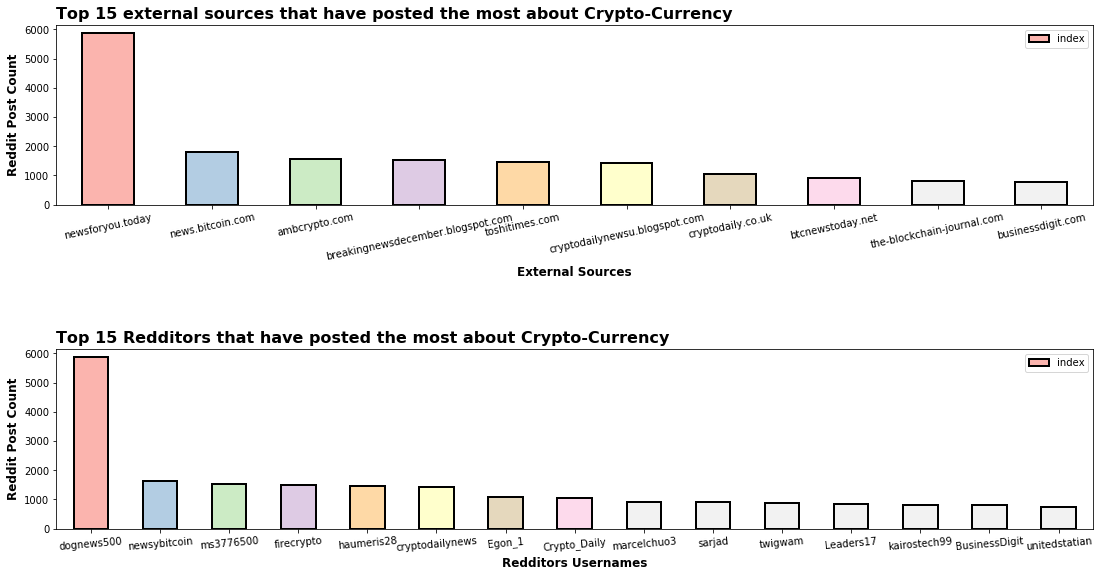

In [18]:
redditer_df = reddit_df.groupby('author').index.count()\
            .sort_values('index',ascending=False)\
            .head(16).reset_index().iloc[1:16]

authors = list(redditer_df.author.values)
author_df = reddit_df[reddit_df.author.isin(authors)]

author_group_df = author_df.groupby('domain').index.count()\
            .sort_values('index',ascending=False).head(10).reset_index()

top_domains = author_df.domain.values
filtered_df = author_df[(author_df.domain.isin(top_domains))]

stopwords=set(['binance boin', 'bitcoin', 'bos', 'ethereum', 'litecoin','stellar', 'tron', 'xrp', 'bitcoin cash','increase', 'decrease','price','strong','week','loss','sell','buy','best','worst'])

def filter_title(x):
    check = stopwords.intersection(set(x.lower().split()))
    if len(check) > 2:
        return True
    else:
        return False

fil = filtered_df[filtered_df.title.apply(lambda x: filter_title(x))].sort_values('compound', ascending=True)

fil.head()
fig,axlist =  plt.subplots(2, 1,figsize=(18,10))
axlist.flatten()[0].set_title('Top 15 external sources that have posted the most about Crypto-Currency',\
                              fontweight="bold",loc='left',fontsize=16)
author_group_df.plot.bar(x='domain', y='index', rot=12, ax= axlist.flatten()[0],\
                         color=plt.cm.Pastel1(np.arange(len(author_group_df))),edgecolor="black", lw=2)
axlist.flatten()[0].set_xlabel('External Sources',fontweight="bold",fontsize=12)
axlist.flatten()[0].set_ylabel('Reddit Post Count',fontweight="bold",fontsize=12)
axlist.flatten()[1].set_title('Top 15 Redditors that have posted the most about Crypto-Currency',\
                              fontweight="bold",loc='left',fontsize=16)

redditer_df.plot.bar(x='author', y='index', rot=5, ax= axlist.flatten()[1],\
                     color=plt.cm.Pastel1(np.arange(len(redditer_df))), edgecolor="black", lw=2)
axlist.flatten()[1].set_xlabel('Redditors Usernames',fontweight="bold",fontsize=12)
axlist.flatten()[1].set_ylabel('Reddit Post Count',fontweight="bold",fontsize=12)
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.20)
plt.subplots_adjust(hspace = 0.8 )


#### EDA Inference
From the above analysis we can tell that a good amount of reddit posts is being generated from sources that have some connection with crypto-currencies in general. 
Also the redditors information in conjunction with external sources information can be used to filter out spams and irrelavent reddit posts. 

## Get Sentiment Distribution for each CryptoCurrency

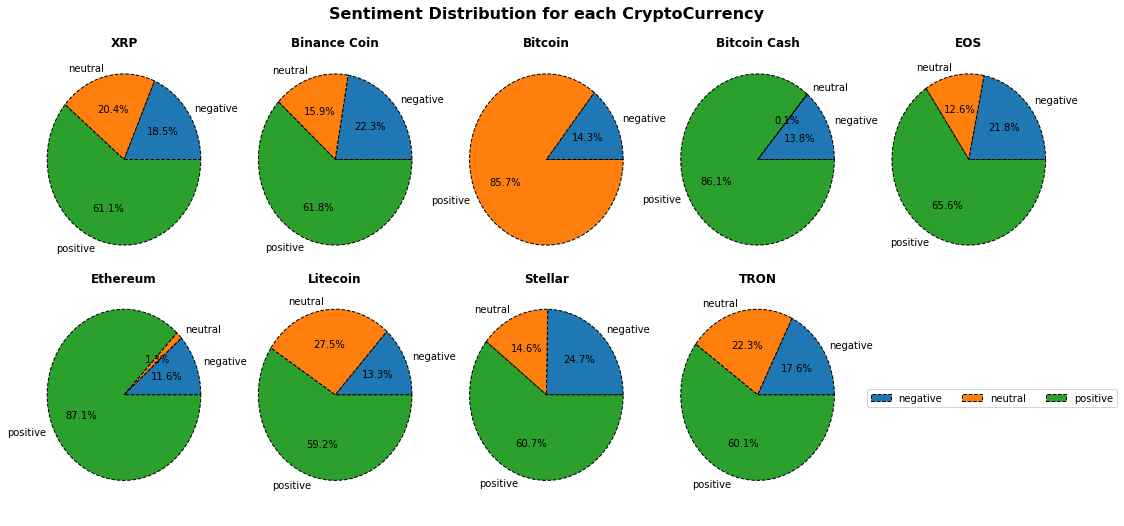

In [4]:
def set_sentiment(x):
    if x > 0: return 'positive'
    elif x == 0: return 'neutral'
    else: return 'negative'
crypto_df['len_reddit'] = crypto_df[crypto_df.reddit_title.notnull()].reddit_title.apply(lambda x: len(x))  
crypto_df['reddit_sentiment'] = crypto_df[crypto_df.reddit_compound.notnull()].reddit_compound.apply(lambda x: set_sentiment(x))   

reddit_count = crypto_df.groupby(['asset_name','reddit_sentiment']).len_reddit.count().reset_index()
coin = reddit_count['asset_name'].unique()

fig,axlist =  plt.subplots(2, 5,figsize=(18,8))
fig.suptitle('Sentiment Distribution for each CryptoCurrency\n\n',fontweight="bold",fontsize=16)
i = 0
for ax in axlist.flatten():
    ax.set_title(coin[i-1],fontweight="bold",loc='center')
    fig.subplots_adjust(bottom=0.20)
    lns1 = ax.pie( 'len_reddit',labels='reddit_sentiment', autopct='%1.1f%%',\
          data=reddit_count[reddit_count['asset_name'] == coin[i-1]],\
         wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed', 'antialiased': True})
    i = i + 1
    if i == 9:
        break;

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axlist.flatten()[9].set_axis_off()
axlist.flatten()[-2].legend(loc='upper right', bbox_to_anchor=(2.4, 0.55), ncol=3)

plt.subplots_adjust(hspace = 0.1,wspace = 0.1 )
plt.show()

#### EDA Inference

From the above pie charts we can see that the sentiment scores are satisfactorly distributed.
- Also we can tell that Ethereum followed by Bitcoin Cash have a good overall sentiment score among redditors.
- Stellar followed by Binance Coin have the highest negative sentiment score among redditors.

## Etherium - Sentiment Score vs Closing Price

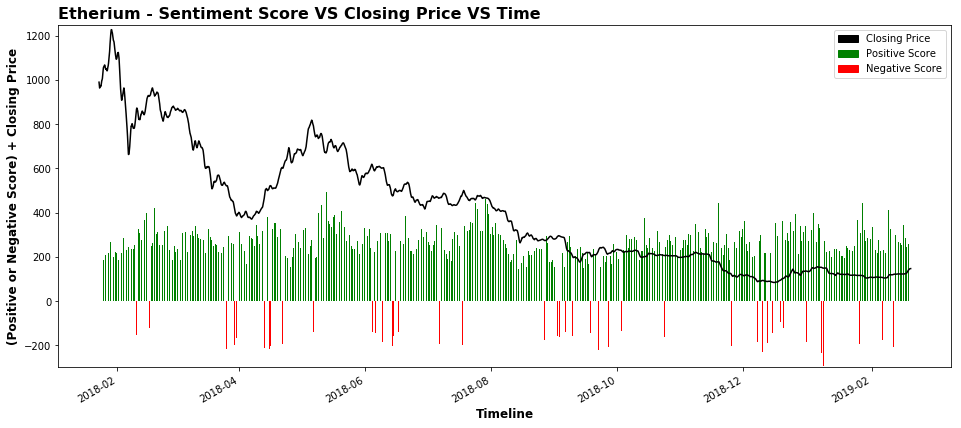

In [16]:
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")
plot_1 = crypto_df[['asset_name','created_utc','reddit_compound','reddit_pos','reddit_score','reddit_neg','close']].sort_values('created_utc')
plot_1 = plot_1[plot_1.asset_name == 'Ethereum']
dF = plot_1.set_index('created_utc')
dF1 = dF[dF['reddit_compound']>=0]
dF2 = dF[dF['reddit_compound']<0]
fig,axes = plt.subplots(figsize=(16,7))
axes.xaxis_date()
axes.plot(mdates.date2num(list(dF.index)),pd.Series.rolling(dF.close,24).mean(),color='black')
axes.bar(mdates.date2num(list(dF1.index)),pd.Series.rolling(dF1.reddit_compound*2000,24).mean(),align='center',width=0.02,color='green')
axes.bar(mdates.date2num(list(dF2.index)),pd.Series.rolling(dF2.reddit_compound*3000,24).mean(),align='center',width=0.02,color='red')
axes.set_title('Etherium - Sentiment Score VS Closing Price VS Time',\
                              fontweight="bold",loc='left',fontsize=16)
axes.set_xlabel('Timeline',fontweight="bold",fontsize=12)
axes.set_ylabel('(Positive or Negative Score) + Closing Price',fontweight="bold",fontsize=12)

red_patch = mpatches.Patch(color='red', label='Negative Score')
green_patch = mpatches.Patch(color='green', label='Positive Score')
black_patch = mpatches.Patch(color='black', label='Closing Price')

plt.legend(handles=[black_patch,green_patch,red_patch])
axes.set_ylim(-300,1250)
fig.autofmt_xdate()

#### EDA Inference

We can infer from the above time series chart, we can see some sort of relationship between the fluctuation of sentiment score with closing price. Now we want to test the reliability of our premise as well as the data itself.

**Premise: In an ideal senario, if the public opinion is bad or good, it should have some influence on the price in most cases. **

**Testing Procedure:** In order to prove the above statement, we have considered the most relavent reddit posts that have extreme cases of a sentiment score. Then we have plotted these events with the closing price of cryptocurrency. Lets see what the results where.

## Etherium -  Extreme Sentiment Score Events VS Closing Price VS Time

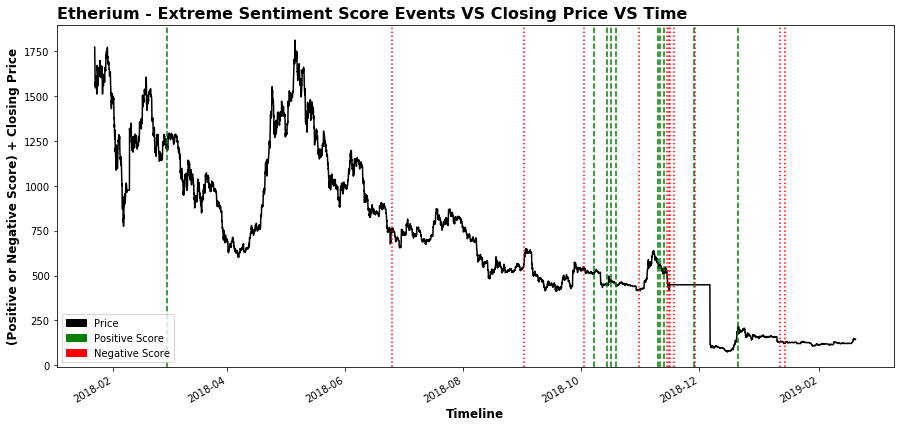

In [19]:
plot_1 = crypto_df[['asset_name','created_utc','reddit_compound','reddit_pos','reddit_score','reddit_neg','close']].sort_values('created_utc')
plot_1 = plot_1[plot_1.asset_name == 'Bitcoin Cash']
temp = fil[fil.subreddit == 'btc'].set_index('created_utc')
dF = plot_1.set_index('created_utc')
dF1 = temp[temp['compound']>=0].head(10)
dF2 = temp[temp['compound']<0]
fig,axes = plt.subplots(figsize=(15,7))
axes.xaxis_date()
axes.plot(mdates.date2num(list(dF.index)),pd.Series.rolling(dF.close,2).mean(),color='black')
for xmaj in mdates.date2num(list(dF1.index)):
    axes.axvline(x=xmaj, ls='--', color='green')
for xmaj in mdates.date2num(list(dF2.index)):
    axes.axvline(x=xmaj, ls=':', color='red')
axes.set_title('Etherium - Extreme Sentiment Score Events VS Closing Price VS Time',\
                              fontweight="bold",loc='left',fontsize=16)
axes.set_xlabel('Timeline',fontweight="bold",fontsize=12)
axes.set_ylabel('(Positive or Negative Score) + Closing Price',fontweight="bold",fontsize=12)

red_patch = mpatches.Patch(color='red', label='Negative Score')
green_patch = mpatches.Patch(color='green', label='Positive Score')
black_patch = mpatches.Patch(color='black', label='Price')

plt.legend(handles=[black_patch,green_patch,red_patch])
fig.autofmt_xdate()

#### EDA Inference

We can infer from the above time series chart, that the** price does fluctuate based on public opinion.**

## CryptoCurrency VS Popularity

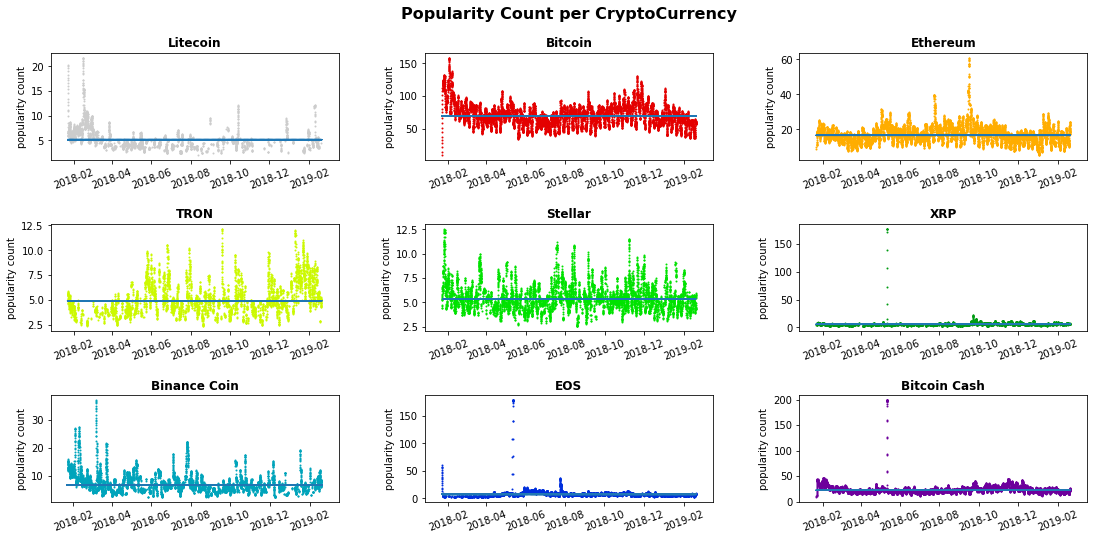

In [24]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

fig,axlist =  plt.subplots(3, 3,figsize=(18,8))
fig.suptitle('Popularity Count per CryptoCurrency\n\n',fontweight="bold",fontsize=16)


x=crypto_df['created_utc']
y=pd.Series.rolling(crypto_df.len_reddit,20).mean()


# Get unique names of species
uniq = list(set(crypto_df['asset_name']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('nipy_spectral_r')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# 
i = 0
for ax in axlist.flatten():
    ax.set_title(uniq[i],fontweight="bold",loc='center')
    fig.subplots_adjust(bottom=0.20)
    indx = crypto_df['asset_name'] == uniq[i]
    y_mean = [y[indx].median()]*len(x)
    ax.scatter(x[indx], y[indx],s=1, color=scalarMap.to_rgba(i), label=uniq[i])
    ax.set_ylabel('popularity count')
    ax.plot(x,y_mean, label='Mean', linestyle='--')
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
    i = i + 1
    if i == 9:
        break;

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value


plt.subplots_adjust(hspace = 0.6,wspace = 0.3 )
plt.show()


From the above graphs We can tell that Bitcoin followed by etherium are the two most talked crypto currencies among redditors.
There is very less discussion happening about XRP or EOS.